In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict

if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [3]:
def mc_prediction_importance_sampling(target_policy, behavior_policy, env, num_episodes, discount_factor=1.0):
    """
    Monte Carlo Off-Policy Prediction using Weighted Importance Sampling. 
    Calculates the value function for a given policy.
    
    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_count = defaultdict(float)
    
    # The final value function
    V = defaultdict(float)
    
    for i in range(num_episodes):
        state = env.reset()
        steps = list()
        observation_count = defaultdict(int)
        while True:
            # On each step take action according to behavior_policy and save (state, action) pair with appropriate reward
            probs = behavior_policy(state)
            action = np.random.choice(env.action_space.n, p=probs)
            new_state, reward, done, _ = env.step(action)
            steps.append((state, action, reward))
            # Count observation to determine first visit to the state
            observation_count[state] += 1
            state = new_state
            if done:
                break
                
        gain = 0
        is_ratio = 1 # importance sampling ratio
        # Add discounted returns following all visited (states, action) pairs
        for step, episode in enumerate(steps[::-1]):
            state, action, reward = episode
            gain = gain * discount_factor + reward
            b_probs = behavior_policy(state)
            t_probs = target_policy(state)
            is_ratio *= t_probs[action] / b_probs[action]
            # If current observation was visited first time, add the return following it
            observation_count[state] -= 1
            if observation_count[state] == 0:
                returns_count[state] += 1
                V[state] += (gain * is_ratio - V[state]) / returns_count[state]
    return V    

In [4]:
def sample_policy(observation):
    """
    A policy that sticks if the player score is > 20 and hits otherwise.
    """
    score, dealer_score, usable_ace = observation
    return np.array((1.0, 0.0)) if score >= 20 else np.array((0.0, 1.0))

In [5]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

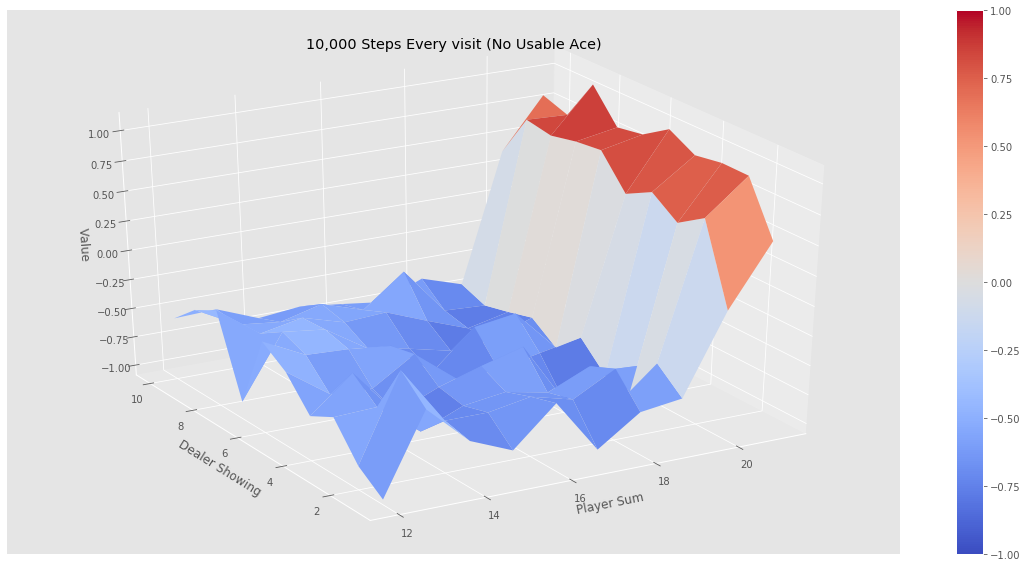

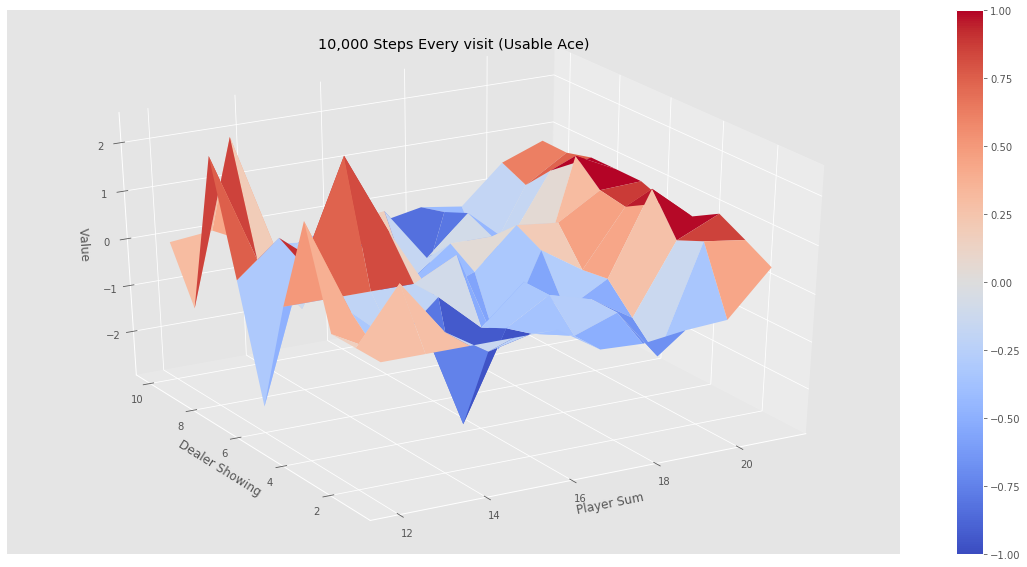

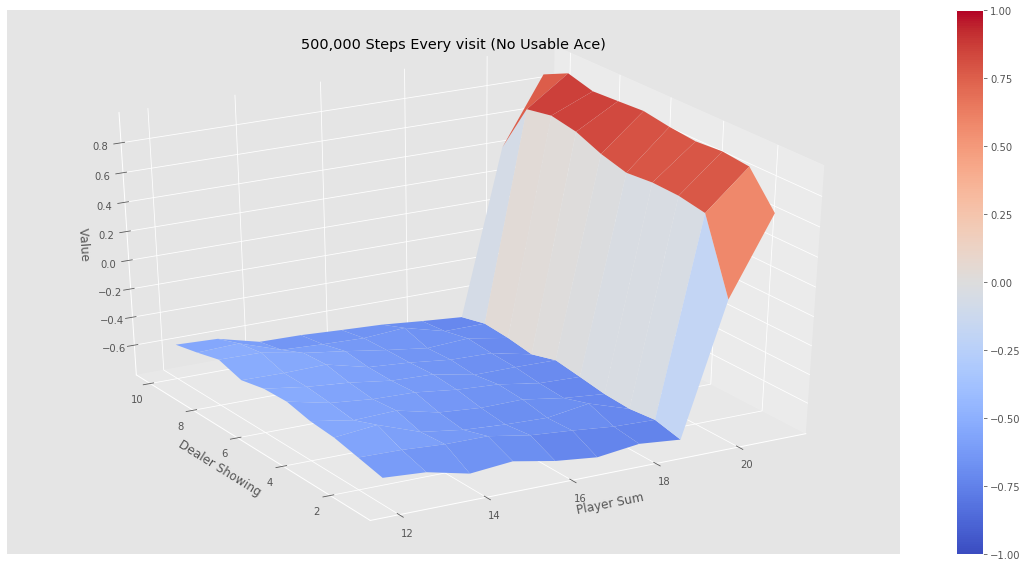

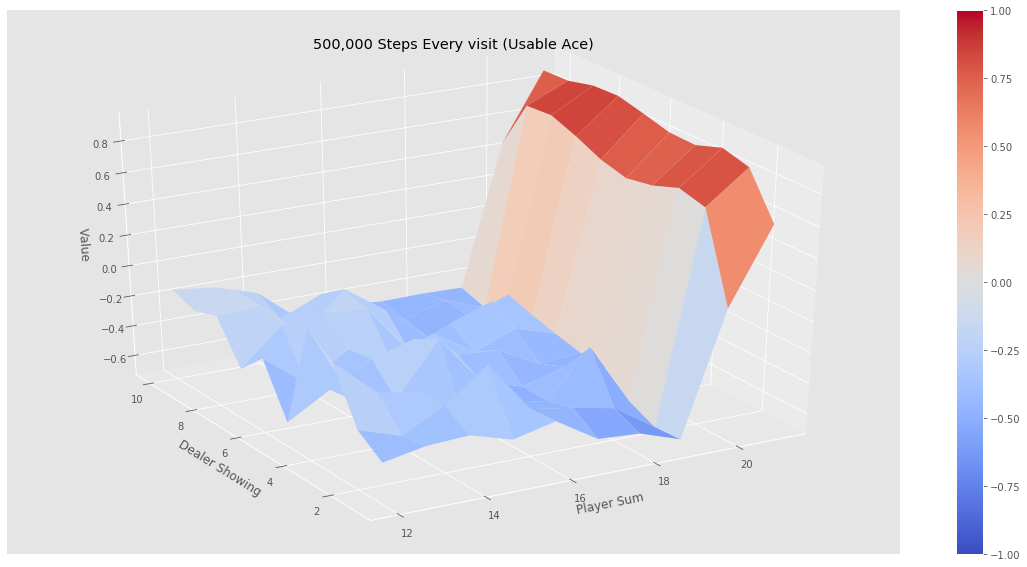

In [6]:
random_policy = create_random_policy(env.action_space.n)
V_10k = mc_prediction_importance_sampling(sample_policy, random_policy, env, num_episodes=10000)
plotting.plot_value_function(V_10k, title="10,000 Steps Every visit")

V_500k = mc_prediction_importance_sampling(sample_policy, random_policy, env, num_episodes=500000)
plotting.plot_value_function(V_500k, title="500,000 Steps Every visit")